# Momentum, Volatility, and Volume Factors in U.S. Stock Returns

**ISYE 4031 Final Project**  
*Regression & Forecasting, Georgia Tech*

## Project Overview

This notebook analyzes the relationship between **momentum**, **volatility**, and **volume** factors in U.S. stock returns using S&P 500 data.

### Research Questions:
1. Do momentum indicators significantly predict future stock returns?
2. How does volatility clustering affect return predictability? 
3. Is trading volume a reliable indicator of price direction?

---

In [1]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
from bs4 import BeautifulSoup
import requests, re
import ta
from scipy import stats
import matplotlib.pyplot as plt

### S&P 500 Stock List
We start by scraping the current S&P 500 stock list from a reliable financial data source.

**Data Source**: [Stock Analysis - S&P 500](https://stockanalysis.com/list/sp-500-stocks/)

**Key Information Collected**:
- Stock symbols (tickers)
- Market capitalization
___

In [2]:
url = 'https://stockanalysis.com/list/sp-500-stocks/'
resp = requests.get(url)
soup = BeautifulSoup(resp.text, 'html.parser')

# Find the table and extract headers
table = soup.find('table', class_='symbol-table svelte-1ro3niy')
headers = [th.get_text(strip=True) for th in table.find('tr').find_all('th')]

# Extract all row data
stocks_data = []
for row in table.find_all('tr')[1:]:  # Skip header row
    row_data = [cell.get_text(strip=True) for cell in row.find_all('td')]
    stocks_data.append(row_data)

# Create DataFrame and set No. column as index
sp500_df = pd.DataFrame(stocks_data, columns=headers)
sp500_df = sp500_df.set_index('No.')

### Stock Selection & Date Range Setup

**Stock Selection Process:**
- Extract first 50 companies from S&P 500 list for analysis
- Focus on established companies for reliable historical data

**Analysis Time Period:**
- **Start Date**: January 1, 2021
- **End Date**: December 27, 2024
- **Duration**: 4 years of market data
- **Purpose**: Capture post-pandemic market trends and recovery patterns

> **Note**: Using a subset of the top 50 stocks for computational efficiency and financial significance.
---

In [3]:
# Change this to 50 later, just 3 now for computing efficiency
num_stocks_chosen = 50

# Adding one to properly reflect the number of stocks chosen when it's 10 or more because of stocks with dots in their tickers being filtered out
num_stocks = num_stocks_chosen + 1 if num_stocks_chosen >= 10 else num_stocks_chosen

# Get the list of stock tickers from the DataFrame
stocks = sp500_df.head(num_stocks)['Symbol'].tolist()

# Filter out all tickers that contain dots (they often cause yfinance issues)
stocks = [ticker for ticker in stocks if '.' not in ticker and ticker not in ['COST', 'INTU']]

# Sort the list of stocks alphabetically
stocks.sort()

# Create start and end date variables for use later
startDate = dt.date(2021, 1, 1)
endDate = dt.date(2024, 12, 27)


# Print out list of stocks chosen and length of list
print(f"Selected stocks: {stocks}")
print(f"Total stocks: {len(stocks)}")

Selected stocks: ['AAPL', 'ABBV', 'ABT', 'AMD', 'AMZN', 'AVGO', 'AXP', 'BAC', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GE', 'GOOG', 'GOOGL', 'GS', 'HD', 'IBM', 'ISRG', 'JNJ', 'JPM', 'KO', 'LIN', 'LLY', 'MA', 'MCD', 'META', 'MRK', 'MS', 'MSFT', 'MU', 'NFLX', 'NVDA', 'ORCL', 'PEP', 'PG', 'PLTR', 'PM', 'RTX', 'TMO', 'TMUS', 'TSLA', 'UNH', 'V', 'WFC', 'WMT', 'XOM']
Total stocks: 48


### Weekly Returns and Factor Calculation

**Objective**: Calculate weekly log returns and prepare data structure for technical indicator analysis.

**Key Metrics**:
- **Weekly Log Returns**: `ln(Close/Open) × 100` for price movement analysis
- **ROC** Rate of Change indicator for momentum analysis.
- **RVOL** Relative Volume indicator for volume analysis.
- **BBW** Bollinger Band width indicator for volatility analysis.

**Data Structure**:
- Multi-level columns for organized factor storage
- Separate columns for each technical indicator per stock
- Week numbering for time series tracking
---

**Download and extract relevant data on a weekly basis**

In [4]:
extended_date = startDate - dt.timedelta(days=80)

# Download weekly data
download = yf.download(
    tickers = stocks,
    start = extended_date,
    end = endDate,
    actions = False, threads = True, auto_adjust = True, rounding = True,
    group_by = 'tickers', 
    interval = '1d'
)

# Extract OCV data
open_data = download.xs('Open', level=1, axis=1)
close_data = download.xs('Close', level=1, axis=1)
volume_data = download.xs('Volume', level=1, axis=1)

# Convert daily to weekly data (Friday close) for analysis
weekly_open = open_data.resample('W-FRI').first()
weekly_close = close_data.resample('W-FRI').last()
weekly_volume = volume_data.resample('W-FRI').sum()

# Filter for display purposes
analysis_start = pd.Timestamp('2021-01-01')
analysis_mask = (weekly_close.index >= analysis_start)

analysis_open = weekly_open.loc[analysis_mask]
analysis_close = weekly_close.loc[analysis_mask]

[*********************100%***********************]  48 of 48 completed


In [19]:
# Create MultiIndex DataFrame (indexed by full weekly data for proper alignment)
columns = []
for ticker in stocks:
    # extend to include log return, ROC, RVOL, BBW for each ticker
    columns.extend([(ticker, 'Log_Return_%'), (ticker, 'ROC'), (ticker, 'RVOL'), (ticker, 'BBW')])
# Make sub-columns accessible
multi_columns = pd.MultiIndex.from_tuples(columns, names=['Ticker', 'Metric'])
# Construct df with weekly data indexed with ALL weekly dates (including lookback period)
weekly_data = pd.DataFrame(index=weekly_close.index, columns=multi_columns)

Ticker             AAPL                        ABBV                 \
Metric     Log_Return_%  ROC RVOL  BBW Log_Return_%  ROC RVOL  BBW   
Date                                                                 
2020-10-16          NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   
2020-10-23          NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   
2020-10-30          NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   
2020-11-06          NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   
2020-11-13          NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   
...                 ...  ...  ...  ...          ...  ...  ...  ...   
2024-11-29          NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   
2024-12-06          NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   
2024-12-13          NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   
2024-12-20          NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   
2024-12-27          NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN   

Ticker              ABT       ...  WFC               WMT                 \
Metric     Log_Return_%  ROC  ... RVOL  BBW Log_Return_%  ROC RVOL  BBW   
Date                          ...                                         
2020-10-16          NaN  NaN  ...  NaN  NaN          NaN  NaN  NaN  NaN   
2020-10-23          NaN  NaN  ...  NaN  NaN          NaN  NaN  NaN  NaN   
2020-10-30          NaN  NaN  ...  NaN  NaN          NaN  NaN  NaN  NaN   
2020-11-06          NaN  NaN  ...  NaN  NaN          NaN  NaN  NaN  NaN   
2020-11-13          NaN  NaN  ...  NaN  NaN          NaN  NaN  NaN  NaN   
...                 ...  ...  ...  ...  ...          ...  ...  ...  ...   
2024-11-29          NaN  NaN  ...  NaN  NaN          NaN  NaN  NaN  NaN   
2024-12-06          NaN  NaN  ...  NaN  NaN          NaN  NaN  NaN  NaN   
2024-12-13          NaN  NaN  ...  NaN  NaN          NaN  NaN  NaN  NaN   
2024-12-20          NaN  NaN  ...  NaN  NaN          NaN  NaN  NaN  NaN   
2024-12-27          NaN  NaN  ...  NaN  NaN          NaN  NaN  NaN  NaN   

Ticker              XOM                 
Metric     Log_Return_%  ROC RVOL  BBW  
Date                                    
2020-10-16          NaN  NaN  NaN  NaN  
2020-10-23          NaN  NaN  NaN  NaN  
2020-10-30          NaN  NaN  NaN  NaN  
2020-11-06          NaN  NaN  NaN  NaN  
2020-11-13          NaN  NaN  NaN  NaN  
...                 ...  ...  ...  ...  
2024-11-29          NaN  NaN  NaN  NaN  
2024-12-06          NaN  NaN  NaN  NaN  
2024-12-13          NaN  NaN  NaN  NaN  
2024-12-20          NaN  NaN  NaN  NaN  
2024-12-27          NaN  NaN  NaN  NaN  

[220 rows x 192 columns]

In [6]:
# Create function to lag indicators by one week. Returns values aligned with weekly_close.index
def lag_indicator(weekly_full):
    lagged_values = []
    for current_week in weekly_close.index:
        prev_week_candidates = weekly_full.index[weekly_full.index < current_week]
        if len(prev_week_candidates) > 0:
            prev_week = prev_week_candidates[-1]
            lagged_values.append(weekly_full.loc[prev_week])
        else:
            lagged_values.append(np.nan)
    return lagged_values

**Calculate and store key indicators**

In [7]:
# Calculate indicators for each stock using TA library
for ticker in stocks:

    # Get full daily time series for calculations (including lookback period)
    ticker_weekly_close = weekly_close[ticker].dropna()
    ticker_weekly_volume = weekly_volume[ticker].dropna()
    
    # 1. Log Returns (current week - already calculated from weekly data)
    # Calculate weekly log returns
    log_returns = (np.log(weekly_close / weekly_open) * 100).round(2)

    weekly_data[(ticker, 'Log_Return_%')] = log_returns[ticker]
    
    # 2. Rate of Change (ROC) - weekly-based 5-week ROC (weekly change_i / weekly change_{i-5}), lagged by 1 week
    # Use the DataFrame `weekly_roc_5w` and lag it by one week (we want t-1 values predicting t)

    # weekly_change: change in close from open
    weekly_change = weekly_close - weekly_open.round(2)
    # weekly_roc_5w: weekly_change_i divided by weekly_change_{i-5} (as percent)
    weekly_roc_5w = (((weekly_change / weekly_change.shift(5))) * 100).round(2)
    # Replace inf values with NaN (occurs when denominator is zero - no price movement in week i-5)
    weekly_roc_5w = weekly_roc_5w.replace([np.inf, -np.inf], np.nan)

    if ticker in weekly_roc_5w.columns:
        roc_weekly_lagged = weekly_roc_5w[ticker].reindex(weekly_close.index).shift(1)
    else:
        roc_weekly_lagged = pd.Series(np.nan, index=weekly_close.index)
    weekly_data[(ticker, 'ROC')] = roc_weekly_lagged.round(2)


    # 3. 36-day Bollinger Band Width (BBW) lagged by 1 week
    bb_indicator = ta.volatility.BollingerBands(close=ticker_weekly_close, window=7, window_dev=2)
    bb_upper = bb_indicator.bollinger_hband()
    bb_lower = bb_indicator.bollinger_lband()
    bb_mavg = bb_indicator.bollinger_mavg()
    
    # Calculate BBW as percentage width
    bbw_weekly_full = ((bb_upper - bb_lower) / bb_mavg) * 100
    bbw_lagged_values = lag_indicator(bbw_weekly_full)
    weekly_data[(ticker, 'BBW')] = pd.Series(bbw_lagged_values, index=weekly_close.index).round(2)

    # 4. Relative Volume (RVOL) - Current volume vs 50-day SMA using TA library, lagged by 1 week
    volume_sma_50d = ta.trend.SMAIndicator(close=ticker_weekly_volume, window=10).sma_indicator()
    rvol_weekly_full = ticker_weekly_volume / volume_sma_50d
    rvol_lagged_values = lag_indicator(rvol_weekly_full)
    weekly_data[(ticker, 'RVOL')] = pd.Series(rvol_lagged_values, index=weekly_close.index).round(2)


# Filter to analysis period only
weekly_data_analysis = weekly_data.loc[analysis_start:].copy()

# Add week numbers as a separate column
weekly_data_analysis.insert(0, 'Week', range(1, len(weekly_data_analysis) + 1))

print(f"Regression Format:")
print("Return_{{i,t}} = β_MOM×ROC_36d_{{i,t-1}} + β_BBW×BBW_36d_{{i,t-1}} + β_VOL×RVOL_50d_{{i,t-1}} + ε_{{i,t}}")


display(weekly_data_analysis.head())


Regression Format:
Return_{{i,t}} = β_MOM×ROC_36d_{{i,t-1}} + β_BBW×BBW_36d_{{i,t-1}} + β_VOL×RVOL_50d_{{i,t-1}} + ε_{{i,t}}


Ticker     Week         AAPL                               ABBV                \
Metric          Log_Return_%      ROC  RVOL    BBW Log_Return_%     ROC  RVOL   
Date                                                                            
2021-01-01    1        -0.97  -439.61  0.83  16.54         3.32   56.94  0.38   
2021-01-08    2        -1.11   217.24  0.86  19.26         0.08  118.52  0.52   
2021-01-15    3        -1.60   -28.02  1.21  18.23         4.33    3.93  1.06   
2021-01-22    4         8.47 -2000.00  0.98  13.00        -0.36 -672.41  1.09   
2021-01-29    5        -8.08   278.23  0.90  15.31        -6.84   13.47  0.72   

Ticker                     ABT  ...   WFC                 WMT                \
Metric        BBW Log_Return_%  ...  RVOL    BBW Log_Return_%     ROC  RVOL   
Date                            ...                                           
2021-01-01  10.49         0.48  ...  0.69  29.62         0.07  700.00  0.93   
2021-01-08   8.17         1.88  ...  0.44  20.20         1.61    7.69  0.74   
2021-01-15   5.64         0.48  ...  1.23  19.31        -0.93  -86.90  1.20   
2021-01-22   9.39         0.98  ...  1.44  19.41         1.17  144.83  1.14   
2021-01-29  11.69         8.91  ...  0.71  19.63        -3.41  -98.15  0.75   

Ticker                    XOM                       
Metric       BBW Log_Return_%     ROC  RVOL    BBW  
Date                                                
2021-01-01  6.60        -1.12  -75.47  0.50  26.64  
2021-01-08  7.05         9.21  -17.27  0.61  19.66  
2021-01-15  6.46         6.14  212.34  1.13  15.47  
2021-01-22  4.41        -2.12  119.49  1.23  20.82  
2021-01-29  3.45        -4.48   62.88  0.73  22.52  

[5 rows x 193 columns]

Function creating dataframe with each week's metrics

In [8]:
# Get unique ticker names from the MultiIndex columns. First one is 'Week' so skip it
stock_tickers = weekly_data_analysis.columns.get_level_values('Ticker').unique().tolist()
stock_tickers = [ticker for ticker in stock_tickers if ticker != 'Week']

# Create dataframe for week data where row is stock ticker and columns are metrics
def get_week_x_data(tickers, week_number):
    week_data = pd.DataFrame(index=tickers, columns=['Log_Return_%', 'ROC', 'RVOL', 'BBW'])
    
    index = week_number - 1  # Convert to zero-based index
    
    for ticker in tickers:
        # Access each metric individually from the MultiIndex DataFrame
        week_data.loc[ticker, 'Log_Return_%'] = weekly_data_analysis[(ticker, 'Log_Return_%')].iloc[index]
        week_data.loc[ticker, 'ROC'] = weekly_data_analysis[(ticker, 'ROC')].iloc[index]
        week_data.loc[ticker, 'RVOL'] = weekly_data_analysis[(ticker, 'RVOL')].iloc[index]
        week_data.loc[ticker, 'BBW'] = weekly_data_analysis[(ticker, 'BBW')].iloc[index]
    
    # Drop row if NaN found in any column
    week_data_clean = week_data.dropna(subset=['Log_Return_%', 'ROC', 'RVOL', 'BBW'])
    return week_data_clean

In [9]:
# Output
week_num = np.random.randint(1, 209)
week_result = get_week_x_data(stock_tickers, week_num)
print(f"Week {week_num} data:")
display(week_result.head())

Week 21 data:


,Log_Return_%,ROC,RVOL,BBW
AAPL,-1.1,-21.57,1.06,11.55
ABBV,-0.55,-3.91,0.94,13.55
ABT,-0.74,-71.93,0.89,7.31
AMD,3.9,-353.92,1.01,13.58
AMZN,-1.33,-29.82,1.22,11.75


**Get Regression Coefficients**

In [10]:
import statsmodels.api as sm

week_num = 4
week_result = get_week_x_data(stock_tickers, week_num)
y = week_result['Log_Return_%'].values.astype(float)
X = week_result[['ROC', 'RVOL', 'BBW']].values.astype(float)
model = sm.OLS(y,X).fit()

print("Week Number: ", week_num)
print(model.summary())

Week Number:  4
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.069
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              1.114
Date:                Mon, 24 Nov 2025   Prob (F-statistic):                       0.354
Time:                        09:38:01   Log-Likelihood:                         -144.16
No. Observations:                  48   AIC:                                      294.3
Df Residuals:                      45   BIC:                                      299.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [11]:
# Create a function to run regression for each week and store results in a DataFrame
def run_weekly_regression(tickers, weekly_data_analysis):
    regression_results = []
    
    for week_num in range(1, len(weekly_data_analysis) + 1):
        week_data = get_week_x_data(tickers, week_num)
        
        y = week_data['Log_Return_%'].values.astype(float)
        X = week_data[['ROC', 'RVOL', 'BBW']].values.astype(float)
        X = sm.add_constant(X)  # Add intercept column
        
        model = sm.OLS(y, X).fit()
        
        regression_results.append({
            'Week': week_num,
            'Intercept': model.params[0],
            'Beta ROC': model.params[1],
            'Beta RVOL': model.params[2],
            'Beta BBW': model.params[3],
            'R-squared': model.rsquared,
            'ROC significance' : 'Significant' if model.pvalues[1] < 0.05 else 'Not Significant',
            'RVOL significance' : 'Significant' if model.pvalues[2] < 0.05 else 'Not Significant',
            'BBW significance' : 'Significant' if model.pvalues[3] < 0.05 else 'Not Significant'
        })
    
    return pd.DataFrame(regression_results)

regression_results_df = run_weekly_regression(stock_tickers, weekly_data_analysis)
print("Weekly Regression Results:")
display(regression_results_df)

avg_betas = regression_results_df[['Beta ROC', 'Beta RVOL', 'Beta BBW', 'R-squared']].mean()
print("Average Betas across all weeks:")
print(avg_betas)
t_stat_roc = stats.ttest_1samp(regression_results_df['Beta ROC'], 0) 
t_stat_rvol = stats.ttest_1samp(regression_results_df['Beta RVOL'], 0)
t_stat_bbw = stats.ttest_1samp(regression_results_df['Beta BBW'], 0)
print(f"T-statistic for Beta ROC: {t_stat_roc.statistic}, P-value: {t_stat_roc.pvalue}")
print(f"T-statistic for Beta RVOL: {t_stat_rvol.statistic}, P-value: {t_stat_rvol.pvalue}")
print(f"T-statistic for Beta BBW: {t_stat_bbw.statistic}, P-value: {t_stat_bbw.pvalue}")

Weekly Regression Results:


,Week,Intercept,Beta ROC,Beta RVOL,Beta BBW,R-squared,ROC significance,RVOL significance,BBW significance
0,1,3.978494,-0.000280,-2.953156,-0.101963,0.237327,Not Significant,Not Significant,Significant
1,2,1.362519,-0.002788,-3.288484,0.188706,0.238762,Not Significant,Not Significant,Significant
2,3,-3.837898,0.001973,0.782248,0.174781,0.201475,Significant,Not Significant,Significant
3,4,3.544957,-0.001570,-1.842351,-0.026692,0.059413,Not Significant,Not Significant,Not Significant
4,5,-2.393504,-0.001793,-0.299063,-0.026577,0.156529,Significant,Not Significant,Not Significant
...,...,...,...,...,...,...,...,...,...
204,205,-3.133349,0.000011,4.274753,-0.046742,0.212594,Not Significant,Significant,Significant
205,206,-0.047553,-0.001434,-2.429987,0.148043,0.257787,Not Significant,Not Significant,Significant
206,207,-1.123366,0.000283,0.140431,-0.002933,0.002543,Not Significant,Not Significant,Not Significant
207,208,-1.084491,0.002205,-1.658141,0.040525,0.053375,Not Significant,Not Significant,Not Significant


Average Betas across all weeks:
Beta ROC     0.000005
Beta RVOL   -0.290607
Beta BBW     0.005906
R-squared    0.142843
dtype: float64
T-statistic for Beta ROC: 0.05135162237176496, P-value: 0.9590946145615495
T-statistic for Beta RVOL: -1.4496094810591715, P-value: 0.14867353114970006
T-statistic for Beta BBW: 0.6100084389142364, P-value: 0.5425220694860593


**Regression Diagnostics**

In [12]:
# Calculate percentage of weeks with significant beta values for each indicator
count_ROC_significance = (regression_results_df['ROC significance'] == 'Significant').sum()
count_RVOL_significance = (regression_results_df['RVOL significance'] == 'Significant').sum()
count_BBW_significance = (regression_results_df['BBW significance'] == 'Significant').sum()

percent_significant_ROC = (count_ROC_significance / len(regression_results_df)) * 100
percent_significant_RVOL = (count_RVOL_significance / len(regression_results_df)) * 100
percent_significant_BBW = (count_BBW_significance / len(regression_results_df)) * 100


print(f"Percent of weeks with significant ROC beta: {percent_significant_ROC:.2f}%")
print(f"Percent of weeks with significant RVOL beta: {percent_significant_RVOL:.2f}%")
print(f"Percent of weeks with significant BBW beta: {percent_significant_BBW:.2f}%")

Percent of weeks with significant ROC beta: 6.70%
Percent of weeks with significant RVOL beta: 11.48%
Percent of weeks with significant BBW beta: 34.93%


# Type I and Type II errors
____

In [13]:
alpha = 0.05
type_I_errors = 1- (1-alpha)**3
print(type_I_errors)
print(f"There is an approximately {type_I_errors*100:.2f}% chance that we will incorrectly reject the null hypothesis that all beta values are equal to zero.")

0.1426250000000001
There is an approximately 14.26% chance that we will incorrectly reject the null hypothesis that all beta values are equal to zero.


**QQ plot for a given week**

Checking that assumptions about model are met: errors are normally distributed, iid, with mean 0 and constant variance

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.069
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              1.114
Date:                Mon, 24 Nov 2025   Prob (F-statistic):                       0.354
Time:                        10:21:44   Log-Likelihood:                         -144.16
No. Observations:                  48   AIC:                                      294.3
Df Residuals:                      45   BIC:                                      299.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

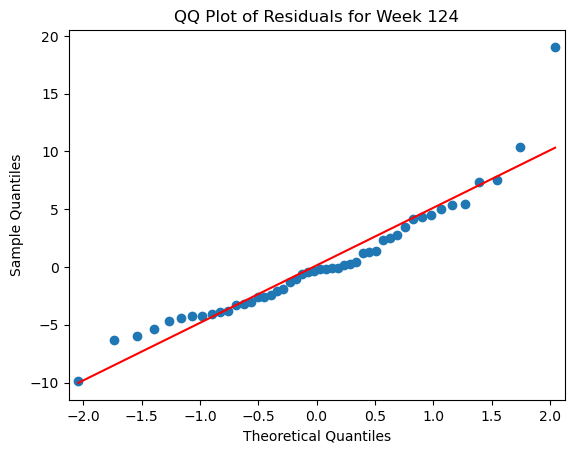

Due to the QQ plot showing that the residuals closely follow the reference line,
 we can conclude that the residuals are approximately normally distributed.
 This suggests that the assumption of normality for the residuals in our regression model is met.
Sum of Squared Errors (SSE) for QQ plot: 746.2430
R-squared for QQ plot: 0.9152289394413453


In [26]:
# QQ plot for a given week
week_num = np.random.randint(1, 209)
week_data = get_week_x_data(stock_tickers, week_num)


####### here model is still referring to model as it was defined earlier. redefine model.
# residuals = model.resid 

y = week_data['Log_Return_%'].values.astype(float)
X = week_data[['ROC', 'RVOL', 'BBW']].values.astype(float)
model = sm.OLS(y, X).fit()
residuals = model.resid

# print(residuals)
print(f"QQ Plot for Week {week_num} Residuals:")

# QQ Plot line ='r'
fig = plt.figure()
ax = fig.add_subplot(111)
fig = sm.qqplot(residuals, line ='r', ax = ax);
ax.set_title(f'QQ Plot of Residuals for Week {week_num}')
plt.show()

print("Due to the QQ plot showing that the residuals closely follow the reference line," \
"\n we can conclude that the residuals are approximately normally distributed." \
"\n This suggests that the assumption of normality for the residuals in our regression model is met.")

# Sum of Squared Errors of QQ plot
theoretical_quantiles = np.sort(stats.norm.ppf((np.arange(1, len(residuals) + 1) - 0.5) / len(residuals)))
sample_quantiles = np.sort(residuals)
sse_qq_plot = np.sum((theoretical_quantiles - sample_quantiles) ** 2)
print(f"Sum of Squared Errors (SSE) for QQ plot: {sse_qq_plot:.4f}")

r = np.corrcoef(theoretical_quantiles, sample_quantiles)[0, 1]
r_squared = r ** 2
print(f"R-squared for QQ plot: {r_squared}")

**Variance Inflation Factor**

In [15]:
# VIF Calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data
X_vif = week_result[['ROC', 'RVOL', 'BBW']].astype(float)
vif_results = calculate_vif(X_vif)
print("VIF Results:")
display(vif_results)

print("None of the VIF values exceed 10, indicating that multicollinearity is not a concern among the predictors.")

VIF Results:


,Feature,VIF
0,ROC,1.114921
1,RVOL,3.236376
2,BBW,3.071717


None of the VIF values exceed 10, indicating that multicollinearity is not a concern among the predictors.


Create scatterplot of Rate of Change vs Log Return for a given week

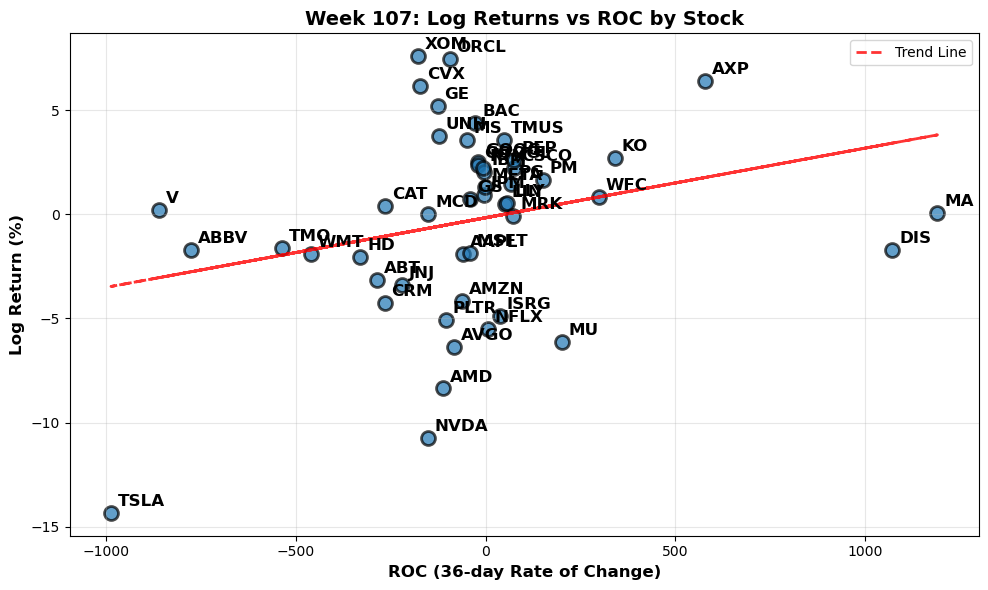

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract week 10 data to ensure non-NaN values
week_data = weekly_data_analysis.iloc[9]  # Week 10 (0-indexed)

# Prepare data for scatter plot
plot_data = []
for ticker in stocks:
    log_return = week_data[(ticker, 'Log_Return_%')]
    roc = week_data[(ticker, 'ROC')]
    
    # Only include if both values are not NaN
    if pd.notna(log_return) and pd.notna(roc):
        plot_data.append({
            'Ticker': ticker,
            'Log_Return_%': log_return,
            'ROC': roc
        })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['ROC'], plot_df['Log_Return_%'], 
           s=100, alpha=0.7, edgecolors='black', linewidth=2)

# Add labels for each point
for i, row in plot_df.iterrows():
    plt.annotate(row['Ticker'], 
                (row['ROC'], row['Log_Return_%']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=12, fontweight='bold')

plt.xlabel('ROC (36-day Rate of Change)', fontsize=12, fontweight='bold')
plt.ylabel('Log Return (%)', fontsize=12, fontweight='bold')
plt.title(f'Week {week_num}: Log Returns vs ROC by Stock', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add a trend line if we have data
if len(plot_df) > 1:
    z = np.polyfit(plot_df['ROC'], plot_df['Log_Return_%'], 1)
    p = np.poly1d(z)
    plt.plot(plot_df['ROC'], p(plot_df['ROC']), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend Line')
    plt.legend()

plt.tight_layout()
plt.show()

Original data shape: (48, 4)
Cleaned data shape: (48, 4)


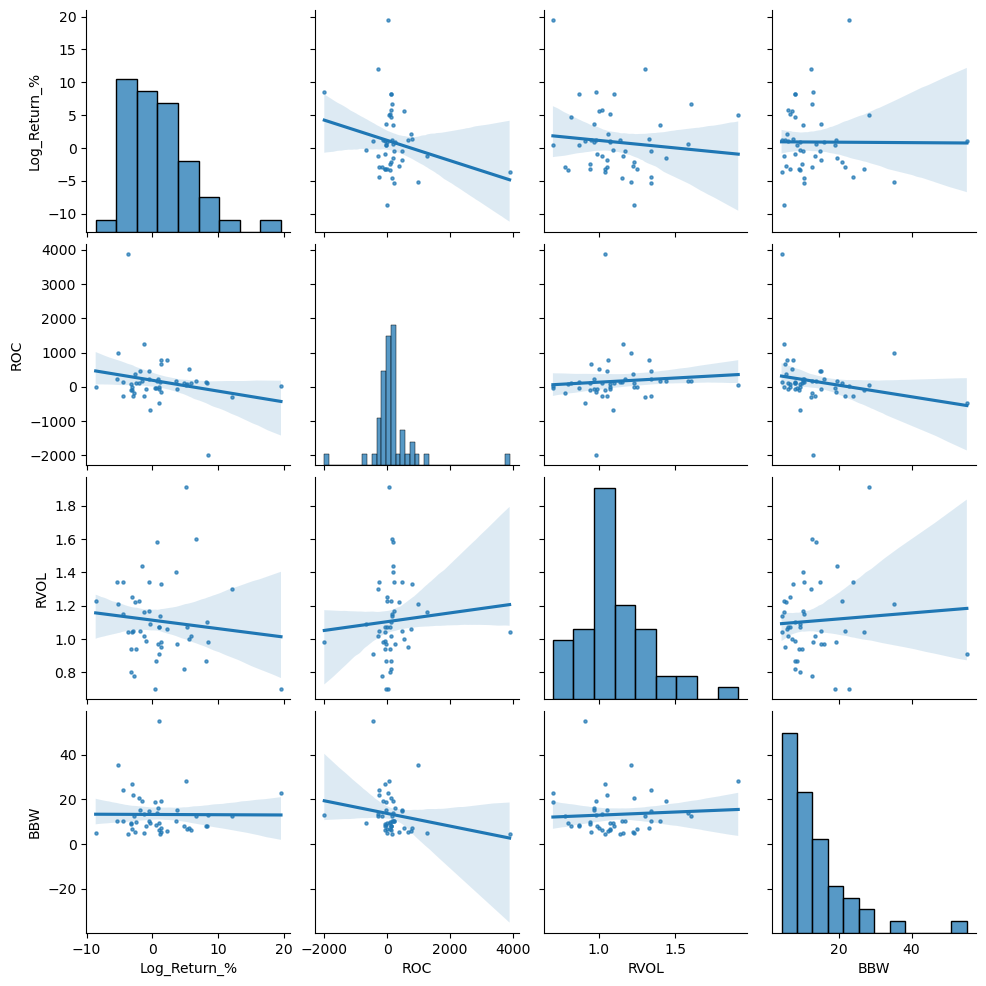

In [17]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# display(week_result)

# Clean the data by replacing inf and -inf values with NaN, then drop NaN rows
week_result_clean = week_result.replace([np.inf, -np.inf], np.nan).infer_objects(copy=False).dropna()

print(f"Original data shape: {week_result.shape}")
print(f"Cleaned data shape: {week_result_clean.shape}")

# Create pairplot for the cleaned week result with trend lines in each scatter plot
# sns.pairplot(week_result_clean, kind='scatter', plot_kws={'alpha': 1})
sns.pairplot(week_result_clean, kind='reg', plot_kws={'scatter_kws': {'alpha': 0.7, 's': 5}}, 
             diag_kind='hist')
plt.show()